In [19]:
import numpy as np
import cv2
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm  
import os


In [20]:
import numpy as np
# from skimage.transform import resize

def resize_digit(base_img, target_size):
    """
    Resize the MNIST digit image to the specified size while maintaining aspect ratio.
    
    Parameters:
        base_img (np.ndarray): The original MNIST digit image.
        target_size (int): The target size for the digit (assumes square output).

    Returns:
        np.ndarray: A resized image of the digit.
    """
    # Resize image to target size with anti-aliasing
    resized_img = cv2.resize(base_img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    # Scale back to [0, 255] as integers
    return (resized_img).astype(np.uint8)

def generate_image(base_img, size, img_size):
    """
    Generate an MNIST digit image with a specified size on a blank canvas, normalized to [0, 1].

    Parameters:
        base_img (np.ndarray): The original MNIST digit image.
        size (float): The relative size of the digit (0, 1].
        img_size (tuple): The canvas size (height, width).

    Returns:
        np.ndarray: A 2D array (float32) representing the image with the resized digit, normalized to [0, 1].
    """
    # Determine target size for the digit
    target_size = max(1, int(size * img_size[0]))  # Ensure size is at least 1 pixel
    resized_digit = resize_digit(base_img, target_size)

    # Create a blank canvas
    canvas = np.zeros(img_size, dtype=np.uint8)

    # Center the digit on the canvas
    pos_y = img_size[0] // 2 - target_size // 2
    pos_x = img_size[1] // 2 - target_size // 2

    # Place the resized digit on the canvas
    canvas[pos_y:pos_y + resized_digit.shape[0], pos_x:pos_x + resized_digit.shape[1]] = resized_digit

    # Normalize to [0, 1] range
    return canvas.astype(np.float32) / 255.


In [21]:
def save_trajectory(images, labels, num_timesteps= 10 , img_size=(32, 32), output_file="trajectories.npz"):
    """
    Save trajectories, their derivatives, and size values for both true and counterfactual scenarios.

    Args:
        images: Array of raw input images.
        labels: Array of labels corresponding to the images.
        num_timesteps: Number of time steps in the trajectory (default: 10).
        img_size: Size of the images.
        output_file: Path to save the output .npz file.
    """
    K = 1
    alpha = .5
    beta = .3
    delta_t = 0.05  # Time step interval

    # Normalize raw images to [0, 1]
    images = images.astype(np.float32)

    # Preallocate lists for structured data
    image_ids = []
    labels_list = []
    true_images = []
    true_derivatives = []
    true_treatments = []
    true_sizes = []  # To store sizes for the true trajectory
    cf_images = []
    cf_derivatives = []
    cf_treatments = []
    cf_sizes = []  # To store sizes for the counterfactual trajectory

    for idx in tqdm(range(len(images))):
        base_img = images[idx]
        digit = labels[idx]

        # Randomly sample treatment group and initial size
        treatment = np.random.randint(0, 2)
        init_size = np.clip(np.random.normal(0.4, 0.2), 0.1, .6)

        # Initialize for true trajectory
        size_t = init_size
        true_traj = []
        true_img_der = []
        true_size_traj = []  # Collect sizes for the true trajectory

        for t in range(num_timesteps):

            img = generate_image(base_img, size_t, img_size)
            d_size_dt = (alpha * digit * (1 - size_t / K) - beta * treatment) * size_t
            size_t += d_size_dt * delta_t
            true_size_traj.append(size_t)

            if t > 0:
                # Compute derivative on normalized images
                img_derivative = (img - true_traj[-1]) / delta_t
                true_img_der.append(img_derivative)
            else:
                true_img_der.append(np.zeros_like(img))

            true_traj.append(img)

        # Initialize for counterfactual trajectory
        cf_treatment = 1 - treatment
        size_t = init_size
        cf_traj = []
        cf_img_der = []
        cf_size_traj = []  # Collect sizes for the counterfactual trajectory

        for t in range(num_timesteps):
            img = generate_image(base_img, size_t, img_size)
            d_size_dt = (alpha * digit * (1 - size_t / K) - beta * cf_treatment) * size_t
            size_t += d_size_dt * delta_t
            cf_size_traj.append(size_t)

            if t > 0:
                # Compute derivative on normalized images
                img_derivative = (img - cf_traj[-1]) / delta_t  # Scale by delta_t
                cf_img_der.append(img_derivative)
            else:
                cf_img_der.append(np.zeros_like(img))

            cf_traj.append(img)

        # Append structured data
        image_ids.append(idx)
        labels_list.append(digit)
        true_images.append(np.array(true_traj))
        true_derivatives.append(np.array(true_img_der))
        true_treatments.append(treatment)
        true_sizes.append(np.array(true_size_traj))
        cf_images.append(np.array(cf_traj))
        cf_derivatives.append(np.array(cf_img_der))
        cf_treatments.append(cf_treatment)
        cf_sizes.append(np.array(cf_size_traj))

    # Save structured data
    np.savez_compressed(output_file,
                        image_ids=np.array(image_ids),
                        labels=np.array(labels_list),
                        true_images=np.array(true_images),
                        true_derivatives=np.array(true_derivatives),
                        true_treatments=np.array(true_treatments),
                        true_sizes=np.array(true_sizes),
                        cf_images=np.array(cf_images),
                        cf_derivatives=np.array(cf_derivatives),
                        cf_treatments=np.array(cf_treatments),
                        cf_sizes=np.array(cf_sizes))





In [22]:
# Load MNIST dataset
train_dataset = datasets.MNIST(root="/cim/anitakriz/vds/data", train=True, download=True)
test_dataset = datasets.MNIST(root="/cim/anitakriz/vds/data", train=False, download=True)

train_images, train_labels = train_dataset.data.numpy(), train_dataset.targets.numpy()
test_images, test_labels = test_dataset.data.numpy(), test_dataset.targets.numpy()

# Sampling ratio (e.g., use 10% of the MNIST data)
sampling_ratio = .5
num_samples = int(len(train_images) * sampling_ratio)
num_test_samples = int(len(test_images) * sampling_ratio)

# Randomly sample indices from the training set
random_indices = np.random.choice(len(train_images), size=num_samples, replace=False)
random_test_indices = np.random.choice(len(test_images), size=num_test_samples, replace=False)

# Subset the images and labels
train_images = train_images[random_indices]
train_labels = train_labels[random_indices]
test_images = test_images[random_test_indices]
test_labels = test_labels[random_test_indices]

# Split the reduced training data into training and validation sets
validation_split = 0.2
num_train = int(len(train_images) * (1 - validation_split))

train_images, val_images = train_images[:num_train], train_images[num_train:]
train_labels, val_labels = train_labels[:num_train], train_labels[num_train:]

# Save the datasets
output_dir = '/cim/anitakriz/vds/data/MNIST/traj/' # TODO modify for your system
os.makedirs(output_dir, exist_ok=True)

# # Generate trajectories for training, validation, and test datasets
train_trajectories = save_trajectory(train_images, train_labels, output_file = os.path.join(output_dir, 'mnist_train_traj.npz') )
val_trajectories = save_trajectory(val_images, val_labels, output_file = os.path.join(output_dir, 'mnist_val_traj.npz'))
test_trajectories = save_trajectory(test_images, test_labels, output_file = os.path.join(output_dir, 'mnist_test_traj.npz'))


100%|██████████| 5000/5000 [00:03<00:00, 1652.58it/s]


(24000, 10, 32, 32)
(24000,)


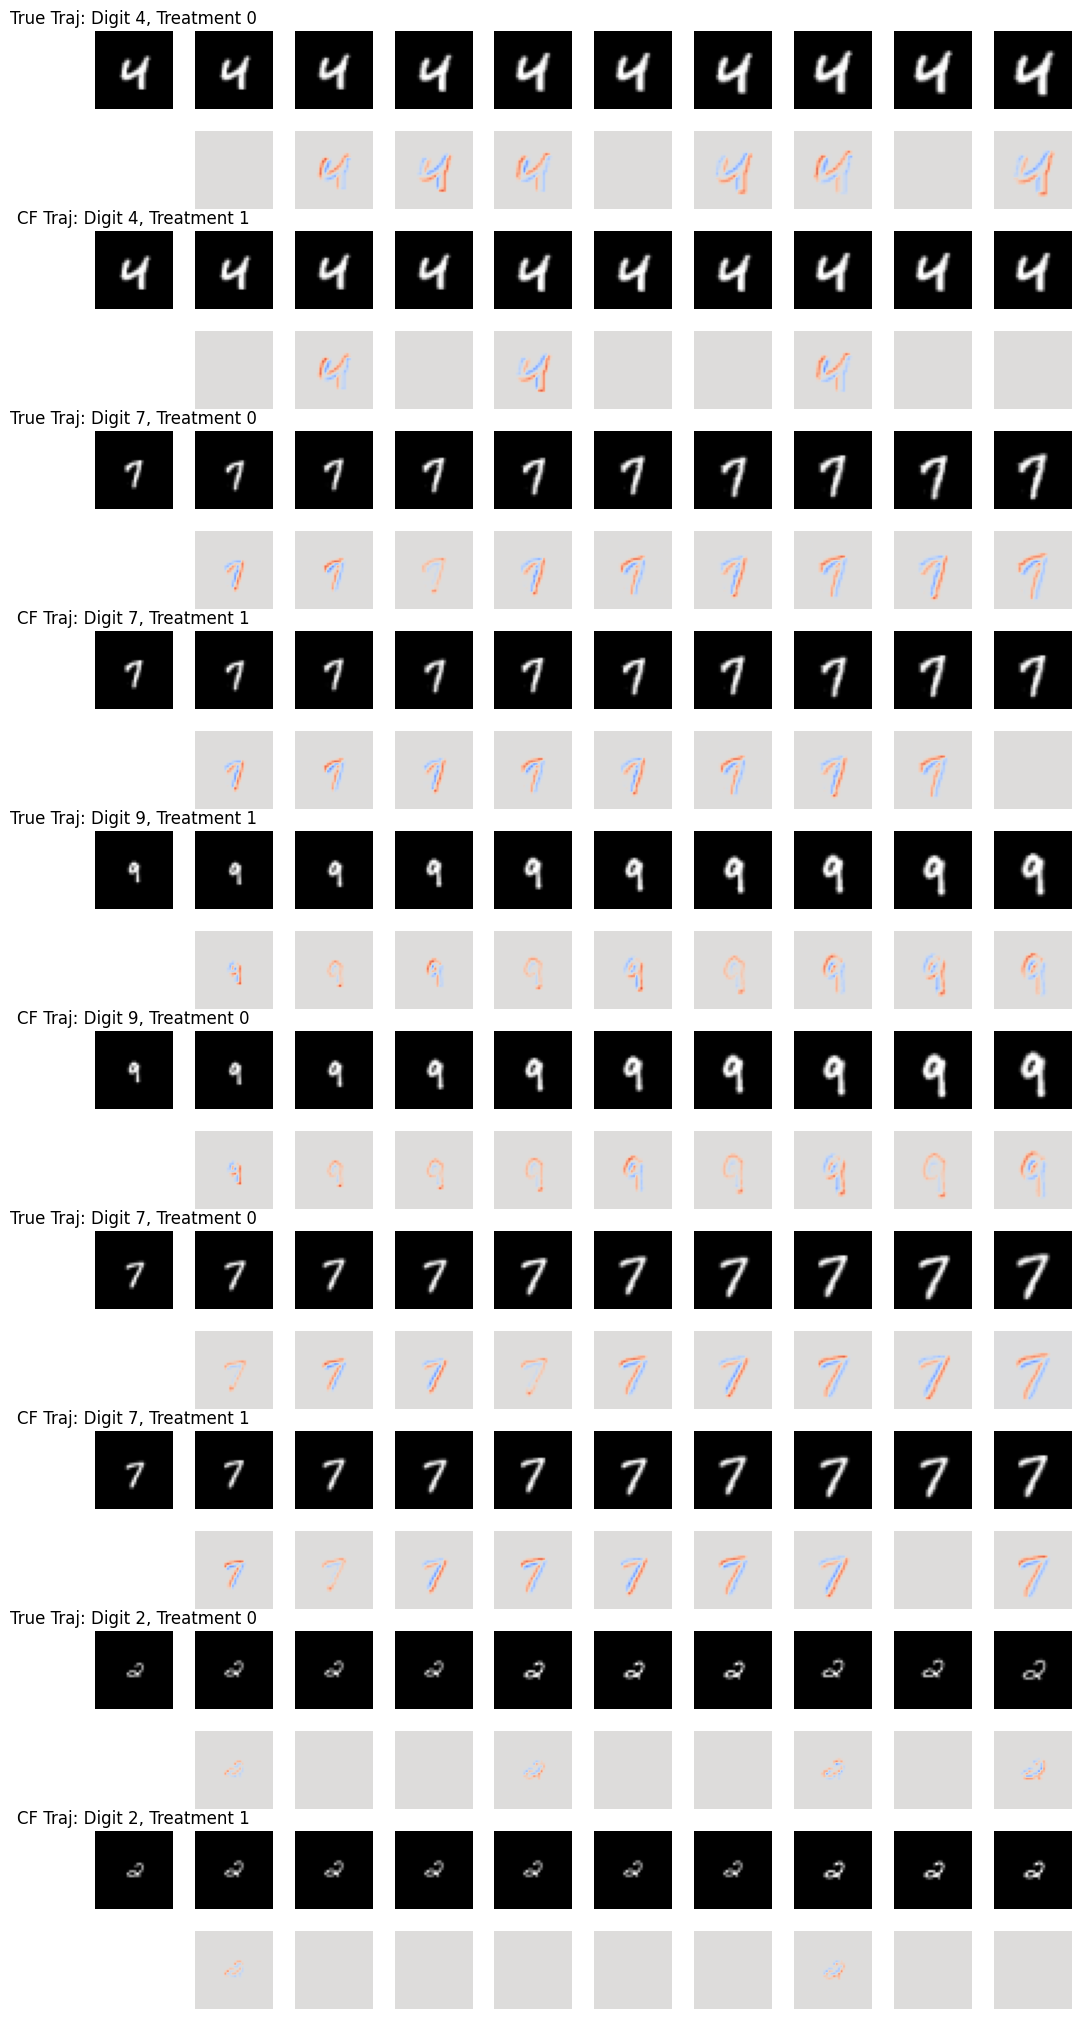

In [ ]:
# Load data
data = np.load('/cim/anitakriz/vds/data/MNIST/traj/mnist_train_traj.npz', allow_pickle=True)
# Extract the data
image_ids = data['image_ids']
labels = data['labels']
true_images = data['true_images']
print(true_images.shape)
true_treatments = data['true_treatments']
print(true_treatments.shape)
cf_images = data['cf_images']
cf_treatments = data['cf_treatments']
true_size = data["true_sizes"]
cf_size = data["cf_sizes"]

# Select parameters
num_samples = 5  # Number of samples to plot
num_timesteps = 10  # Number of timepoints to display

# Evenly spaced time indices
original_timepoints = true_images.shape[1]
time_indices = np.linspace(0, original_timepoints - 1, num_timesteps, dtype=int)

# Create the figure and axes for the plot
fig = plt.figure(figsize=(num_timesteps , 4 * num_samples))

# Add subplots dynamically
for i in range(num_samples):
    digit = labels[i]
    treatment = true_treatments[i]
    cf_treatment = cf_treatments[i]

    # Subsample the true and counterfactual trajectories
    true_subsampled = true_images[i][time_indices]
    cf_subsampled = cf_images[i][time_indices]
    true_size_subsampled = true_size[i][time_indices]  # Extract true sizes for each timestep
    cf_size_subsampled = cf_size[i][time_indices]      # Extract counterfactual sizes for each timestep

    # True trajectory images and sizes
    for t in range(num_timesteps):
        ax = fig.add_subplot(4 * num_samples, num_timesteps, i * num_timesteps * 4 + t + 1)
        ax.imshow(true_subsampled[t], cmap="gray")
        ax.axis("off")
        ax.text(0.5, 1.05, f"{true_size_subsampled[t]:.2f}", ha='center', va='bottom', transform=ax.transAxes, fontsize=10, color="red")
        if t == 0:
            ax.set_title(f"True Traj: Digit {digit}, Treatment {treatment}")

    # Counterfactual trajectory images and sizes
    for t in range(num_timesteps):
        ax = fig.add_subplot(4 * num_samples, num_timesteps, i * num_timesteps * 4 + 2 * num_timesteps + t + 1)
        ax.imshow(cf_subsampled[t], cmap="gray")
        ax.axis("off")
        ax.text(0.5, 1.05, f"{cf_size_subsampled[t]:.2f}", ha='center', va='bottom', transform=ax.transAxes, fontsize=10, color="blue")
        if t == 0:
            ax.set_title(f"CF Traj: Digit {digit}, Treatment {cf_treatment}")

# Adjust layout and display
plt.tight_layout(pad=0.005)
plt.show()





